# Deep Deterministic Policy Gradient

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from buffer import ReplayBuffer
from model import PolicyNetwork, ValueNetwork

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 32
GAMMA = 0.99
TAU = 1e-2
ACTOR_LR = 1e-3
CRITIC_LR = 1e-3
PRINT_EVERY = 1

## Set Environment

In [7]:
ENV_NAME = 'Pendulum-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(3,)
Action space Box(1,)


## Define [DDPG](https://arxiv.org/pdf/1509.02971.pdf) Agent

In [9]:
class DDPGAgent():
    
    def __init__(self, env, seed):
        
        self.env = env
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
        self.gamma = GAMMA
        self.actor_lr = ACTOR_LR
        self.critic_lr = CRITIC_LR
        self.tau = TAU
        
        # initialize actor and critic networks
        self.actor = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        self.actor_target = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        
        self.critic = ValueNetwork(self.state_size, self.action_size, seed).to(device)
        self.critic_target = ValueNetwork(self.state_size, self.action_size, seed).to(device)
        
        # copy critic target parameters
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
            
        # set optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.critic_lr)
        
        # set helpers
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        
    def memorize(self, state, action, reward, next_state, done):

        self.buffer.add(state, action, reward, next_state, done)
    
        # if enough samples are available in memory, get random subset and learn
        if len(self.buffer) > BATCH_SIZE:
            experiences = self.buffer.sample()
            self.learn(experiences, self.gamma)
        
    def act(self, state):
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.actor(state)
        action = action.squeeze(0).cpu().detach().numpy()
        
        return action
    
    def learn(self, experiences, gamma):
        
        states, actions, rewards, next_states, dones = experiences
        
        # obtain Q expected
        Q_expected = self.critic(states, actions)
        
        next_actions = self.actor_target(next_states)
        Q_target_next = self.critic_target(next_states, next_actions.detach())
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next)
        
        # compute loss
        Q_loss = F.mse_loss(Q_expected, Q_target.detach())
        
        # minimize Q loss
        self.critic_optimizer.zero_grad()
        Q_loss.backward()
        self.critic_optimizer.step()
        
        # update actor
        policy_loss = -self.critic(states, self.actor(states)).mean()
        
        # minimize policy loss
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            
    def save(self, actor_path, critic_path):
        
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        torch.save(agent.actor.state_dict(), actor_path); torch.save(agent.critic.state_dict(), critic_path)

In [10]:
agent = DDPGAgent(env, seed=90)

## Train The Agent

In [11]:
def train_agent(num_episodes=100, max_time=500):
    
    scores = []
    scores_window = deque(maxlen=1)
    
    for i_episode in range(1, num_episodes+1):
        
        state = env.reset()
        score = 0
        
        for time_step in range(max_time):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            
            score += reward
            if done:
                break
        
        scores_window.append(score)
        scores.append(score)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= -100.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            agent.save(f'./agents/ACTOR_{ENV_NAME}.pth', f'./agents/CRITIC_{ENV_NAME}.pth')
            break
            
    print('Training completed.')
    
    return scores

In [12]:
scores = train_agent(num_episodes=100, max_time=500)

Episode: 1, Average Score: -3744.17
Episode: 2, Average Score: -3266.24
Episode: 3, Average Score: -3156.38
Episode: 4, Average Score: -4327.30
Episode: 5, Average Score: -3497.74
Episode: 6, Average Score: -3510.68
Episode: 7, Average Score: -3501.88
Episode: 8, Average Score: -3502.31
Episode: 9, Average Score: -3499.28
Episode: 10, Average Score: -3400.49
Episode: 11, Average Score: -3372.77
Episode: 12, Average Score: -3508.01
Episode: 13, Average Score: -3338.05
Episode: 14, Average Score: -3480.83
Episode: 15, Average Score: -3432.34
Episode: 16, Average Score: -3372.62
Episode: 17, Average Score: -3348.93
Episode: 18, Average Score: -3347.38
Episode: 19, Average Score: -1662.82
Episode: 20, Average Score: -1406.89
Episode: 21, Average Score: -1138.61
Episode: 22, Average Score: -3393.46
Episode: 23, Average Score: -502.80
Episode: 24, Average Score: -617.37
Episode: 25, Average Score: -3175.00
Episode: 26, Average Score: -488.42
Episode: 27, Average Score: -130.41
Episode: 28, A

## Evaluate The Agent

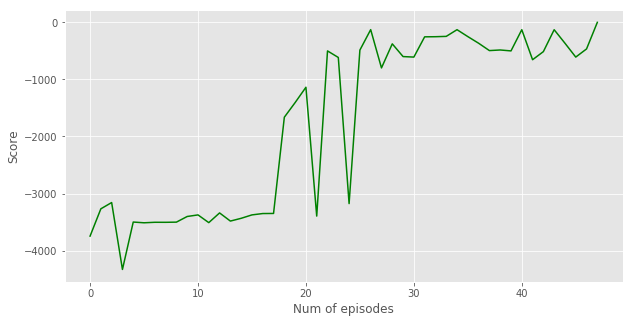

In [13]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_a2c_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agen

In [14]:
num_episodes = 5

for i_episode in range(1, num_episodes+1):
    
    state = env.reset()
    rewards = []
    for time_step in range(1000):
        
        env.render() # render the screen
        
        action = agent.act(state) # select an action
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        rewards.append(reward)
        if done:
            break
            
    print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

env.close()

Episode: 1, Average Score: -489.09
Episode: 2, Average Score: -370.29
Episode: 3, Average Score: -488.20
Episode: 4, Average Score: -0.37
Episode: 5, Average Score: -252.59


---